In [2]:
import numpy as np
import pandas as pd
import collections
from statistics import mean
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

Import the SIGNOR 3.0 database https://signor.uniroma2.it/downloads.php?beta=3.0 organism = Homo sapiens

In [3]:
def signor_input(pathway):
    ppi_signor = pd.read_csv(pathway, sep = '\t')
    ppi_signor = ppi_signor[['ENTITYA', 'TYPEA', 'ENTITYB', 'TYPEB', 'EFFECT', 'SCORE', 'DIRECT','MECHANISM']]
    size = len(ppi_signor.index)
    for i in range(size):
        type1 = ppi_signor.loc[i, 'TYPEA']
        type2 = ppi_signor.loc[i, 'TYPEB']
        if (type1 != 'protein' and type1 != 'complex') or (type2 != 'protein' and type2 != 'complex'):
            ppi_signor = ppi_signor.drop(i)
        else:
            if type1 == 'complex':
                t = ppi_signor.loc[i, 'ENTITYA'].split('/')[-1]
                ppi_signor.loc[i,'ENTITYA'] = t
            if type2 == 'complex':
                t = ppi_signor.loc[i, 'ENTITYB'].split('/')[-1]
                ppi_signor.loc[i,'ENTITYB'] = t
    ppi_signor = ppi_signor.drop_duplicates()
    ppi_signor = ppi_signor.fillna(0)
    return ppi_signor

In [4]:
all_ppi = signor_input('all_data.tsv')
all_ppi.head()

,ENTITYA,TYPEA,ENTITYB,TYPEB,EFFECT,SCORE,DIRECT,MECHANISM
0,CAMK2A,protein,CACNA1S,protein,up-regulates activity,0.360,YES,phosphorylation
1,CAMK2A,protein,PEA15,protein,up-regulates,0.100,YES,phosphorylation
2,CAMK2A,protein,SMAD2,protein,down-regulates,0.525,YES,phosphorylation
5,CAMK2A,protein,FBXO43,protein,up-regulates activity,0.297,YES,phosphorylation
6,CAMK2A,protein,ANKS1B,protein,down-regulates activity,0.160,YES,phosphorylation


Load differential gene expression (DEP) dataframe

In [5]:
dep = pd.read_csv('ras_t&g.csv', sep = ',')

Get significant genes from the DEP. 

In [8]:
# args: cutoff--|logFC| cutoff; pathway_list-- if you'd like to apply the gene regulations in a specific pathway, pathway_list is the list of genes in the pathway. 
# If all data space analysis, leave it default.

#output: dep_s--gene symbol [list] for significant genes, dep_com-- gene_symbol [list] in pathway
#dep_com_s-- significant gene [list] in pathway, dep_s_wc-- significant gene [list] with cutoff = 0

def dep_info(cutoff = 0.1, pathway_list = []):
    sym_list = dep['symbol'].tolist()
    dep_s_wc = list(set(dep.loc[dep['FDR'] < 0.05]['symbol'].tolist()) & set(dep.loc[dep['PValue'] < 0.05]['symbol'].tolist()))
    dep_s = []
    for item in dep_s_wc:
        logfc = dep.loc[dep.symbol == item]['logFC'].values[0]
        if logfc > cutoff or logfc < -cutoff:
            dep_s.append(item)
    dep_com = [item for item in pathway_list if item in deplist]
    dep_com_s = [item for item in pathway_list if item in dep_s]
    return dep_s_wc, dep_s, dep_com, dep_com_s

In [9]:
cutoff = 0.2
dep_s_wc, dep_s, dep_com, dep_com_s = dep_info(cutoff = cutoff)

In [10]:
print('The number of significant genes with absolute logFC larger than {} is {}'.format(cutoff, len(dep_s)))

The number of significant genes with absolute logFC larger than 0.2 is 1908


Get all the directed interaction for the significant genes from Signor.

In [11]:
# args: cutoff--confidence score cutoff for interaction
def background_ppi(sig_genes, cutoff = 0.5):
    all_t = pd.DataFrame(columns = ['ENTITYA', 'ENTITYB', 'SCORE', 'EFFECT', 'MECHANISM'])
    for i in all_ppi.index:
        if all_ppi.loc[i,'DIRECT']=='YES' and all_ppi.loc[i,'SCORE']> cutoff:
            if all_ppi.loc[i, 'ENTITYA'] in sig_genes:
                if all_ppi.loc[i,'EFFECT'].find('up-regulates')>=0:
                    effect = 'up'
                elif all_ppi.loc[i,'EFFECT'].find('down-regulates')>=0:
                    effect = 'down'
                all_t.loc[len(all_t.index)] = [all_ppi.loc[i, 'ENTITYA'], all_ppi.loc[i, 'ENTITYB'], all_ppi.loc[i, 'SCORE'], effect, all_ppi.loc[i,'MECHANISM']]
    return all_t

In [12]:
all_r = background_ppi(dep_s)
all_r = all_r.loc[all_r.ENTITYB.isin(dep_s_wc)]
all_r = all_r.drop_duplicates()
all_r = all_r.loc[all_r.MECHANISM != 0]
all_r.head()

,ENTITYA,ENTITYB,SCORE,EFFECT,MECHANISM
0,SH2B3,JAK2,0.510,down,binding
1,JAG2,NOTCH1,0.591,up,binding
2,JAG2,NOTCH2,0.609,up,binding
3,JAG2,NOTCH3,0.591,up,binding
4,AKT3,FOXO3,0.626,down,phosphorylation


Get logFC information for each genes(nodes) in the network. Output is the logFC dictionary with format {Gene symbol: logFC}.

In [13]:
# args: dep--DEP dataframe; gene_list--gene symbols [list] in the network
def dep_logFC(dep, gene_list):
    dep_dict = {}
    for item in gene_list:
        logFC_m = mean(dep[dep['symbol'] == item]['logFC'].tolist())
        dep_dict[item] = logFC_m
    return dep_dict

In [14]:
all_list = list(set(all_r.ENTITYA.tolist()) | set(all_r.ENTITYB.tolist()))
logFC_all = dep_logFC(dep, all_list)

Only catch the one-to-one driven-corresponding gene-to-gene pair

In [15]:
entityb = all_r.ENTITYB.tolist()
c = collections.Counter(entityb)
enb = [item for item in c if c[item] ==1]
all_1 = all_r.loc[all_r.ENTITYB.isin(enb)]
mechanism = list(set(all_1.MECHANISM.tolist()))
all_1.head()

,ENTITYA,ENTITYB,SCORE,EFFECT,MECHANISM
4,AKT3,FOXO3,0.626,down,phosphorylation
7,WNK2,WNK1,0.577,up,phosphorylation
37,DENND3,RAB12,0.509,up,guanine nucleotide exchange factor
40,ARNTL,ARNTL,0.811,down,binding
53,AURKA,TACC3,0.928,up,phosphorylation


In [18]:
def diff_matrix(df):
    for i in df.index:
        driven = df.loc[i, 'ENTITYA']
        coresp = df.loc[i, 'ENTITYB']
        df.loc[i, 'logFCA'] = logFC_all[driven]
        df.loc[i, 'logFCB'] = logFC_all[coresp]
    for i in df.index:
        effect = df.loc[i, 'EFFECT']
        logFC_a = df.loc[i, 'logFCA']
        logFC_b = df.loc[i, 'logFCB']
        if effect == 'up': 
            if logFC_a * logFC_b > 0:
                df.loc[i,'CLASS'] = 1
            else:
                df.loc[i, 'CLASS'] = 0
        else:
            df.loc[i,'CLASS'] = 1 if logFC_a*logFC_b < 0 else 0
    df = df.drop_duplicates()
    overall_ratio = (sum(df.CLASS.tolist())/len(df.CLASS.tolist())) 
    return overall_ratio

In [19]:
for m in mechanism:
    all_df = all_1.loc[all_1.MECHANISM == m]
    o = diff_matrix(all_df)
    print('Rate for {} is: {}'.format(m, o))
o = diff_matrix(all_1)
print('Rate for all the interaction is:{}'.format(o))

C:\Users\22che\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\22che\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Rate for cleavage is: 0.5
Rate for binding is: 0.6190476190476191
Rate for dephosphorylation is: 0.25
Rate for phosphorylation is: 0.7
Rate for transcriptional regulation is: 0.5
Rate for relocalization is: 1.0
Rate for ubiquitination is: 1.0
Rate for guanine nucleotide exchange factor is: 1.0
Rate for all the interaction is:0.65625


Generate the interaction network.

In [20]:
# Edge information: activation or inhibition
def edge_information(all_df):
    act_edge = []
    inh_edge = []
    act_weight = []
    inh_weight = []
    for i in all_df.index:
        if all_df.loc[i,'EFFECT']=='up':
            act_edge.append((all_df.loc[i,'ENTITYA'], all_df.loc[i,'ENTITYB']))
            act_weight.append(all_df.loc[i, 'SCORE'])
        elif all_df.loc[i,'EFFECT']=='down':
            inh_edge.append((all_df.loc[i,'ENTITYA'], all_df.loc[i,'ENTITYB']))
            inh_weight.append(all_df.loc[i, 'SCORE'])
    return act_edge, inh_edge, act_weight, inh_weight

In [21]:
act_edge, inh_edge, act_weight, inh_weight = edge_information(all_r)

In [22]:
print('The number of activation and inhibition is {} and {}'.format(len(act_edge), len(inh_edge)))

The number of activation and inhibition is 183 and 76


In [26]:
G = nx.from_pandas_edgelist(all_r, source = 'ENTITYA', target = 'ENTITYB', edge_attr = 'SCORE', create_using=nx.DiGraph())
pos = nx.spring_layout(G, seed = 24)

In [27]:
# Node information: logFC
def color_story(logfc_dict):
    up, down, na, c_up, c_down, c_na = [], [], [], [],[],[]
    for node in G.nodes():
        if node not in logfc_dict:
            na.append(node)
            c_na.append(0)
        elif logfc_dict[node]>0:
            up.append(node)
            c_up.append(logfc_dict[node])
        else:
            down.append(node)
            c_down.append(logfc_dict[node])
    return up, down, na, c_up, c_down, c_na

In [28]:
up, down, na, c_up, c_down, c_na = color_story(logFC_all)

In [29]:
print('The number of upregulated and downregulated genes are {} and {}'.format(len(up), len(down)))

The number of upregulated and downregulated genes are 96 and 128


In [30]:
# Label information
labels = {}
for node in G.nodes():
    labels[node] = node

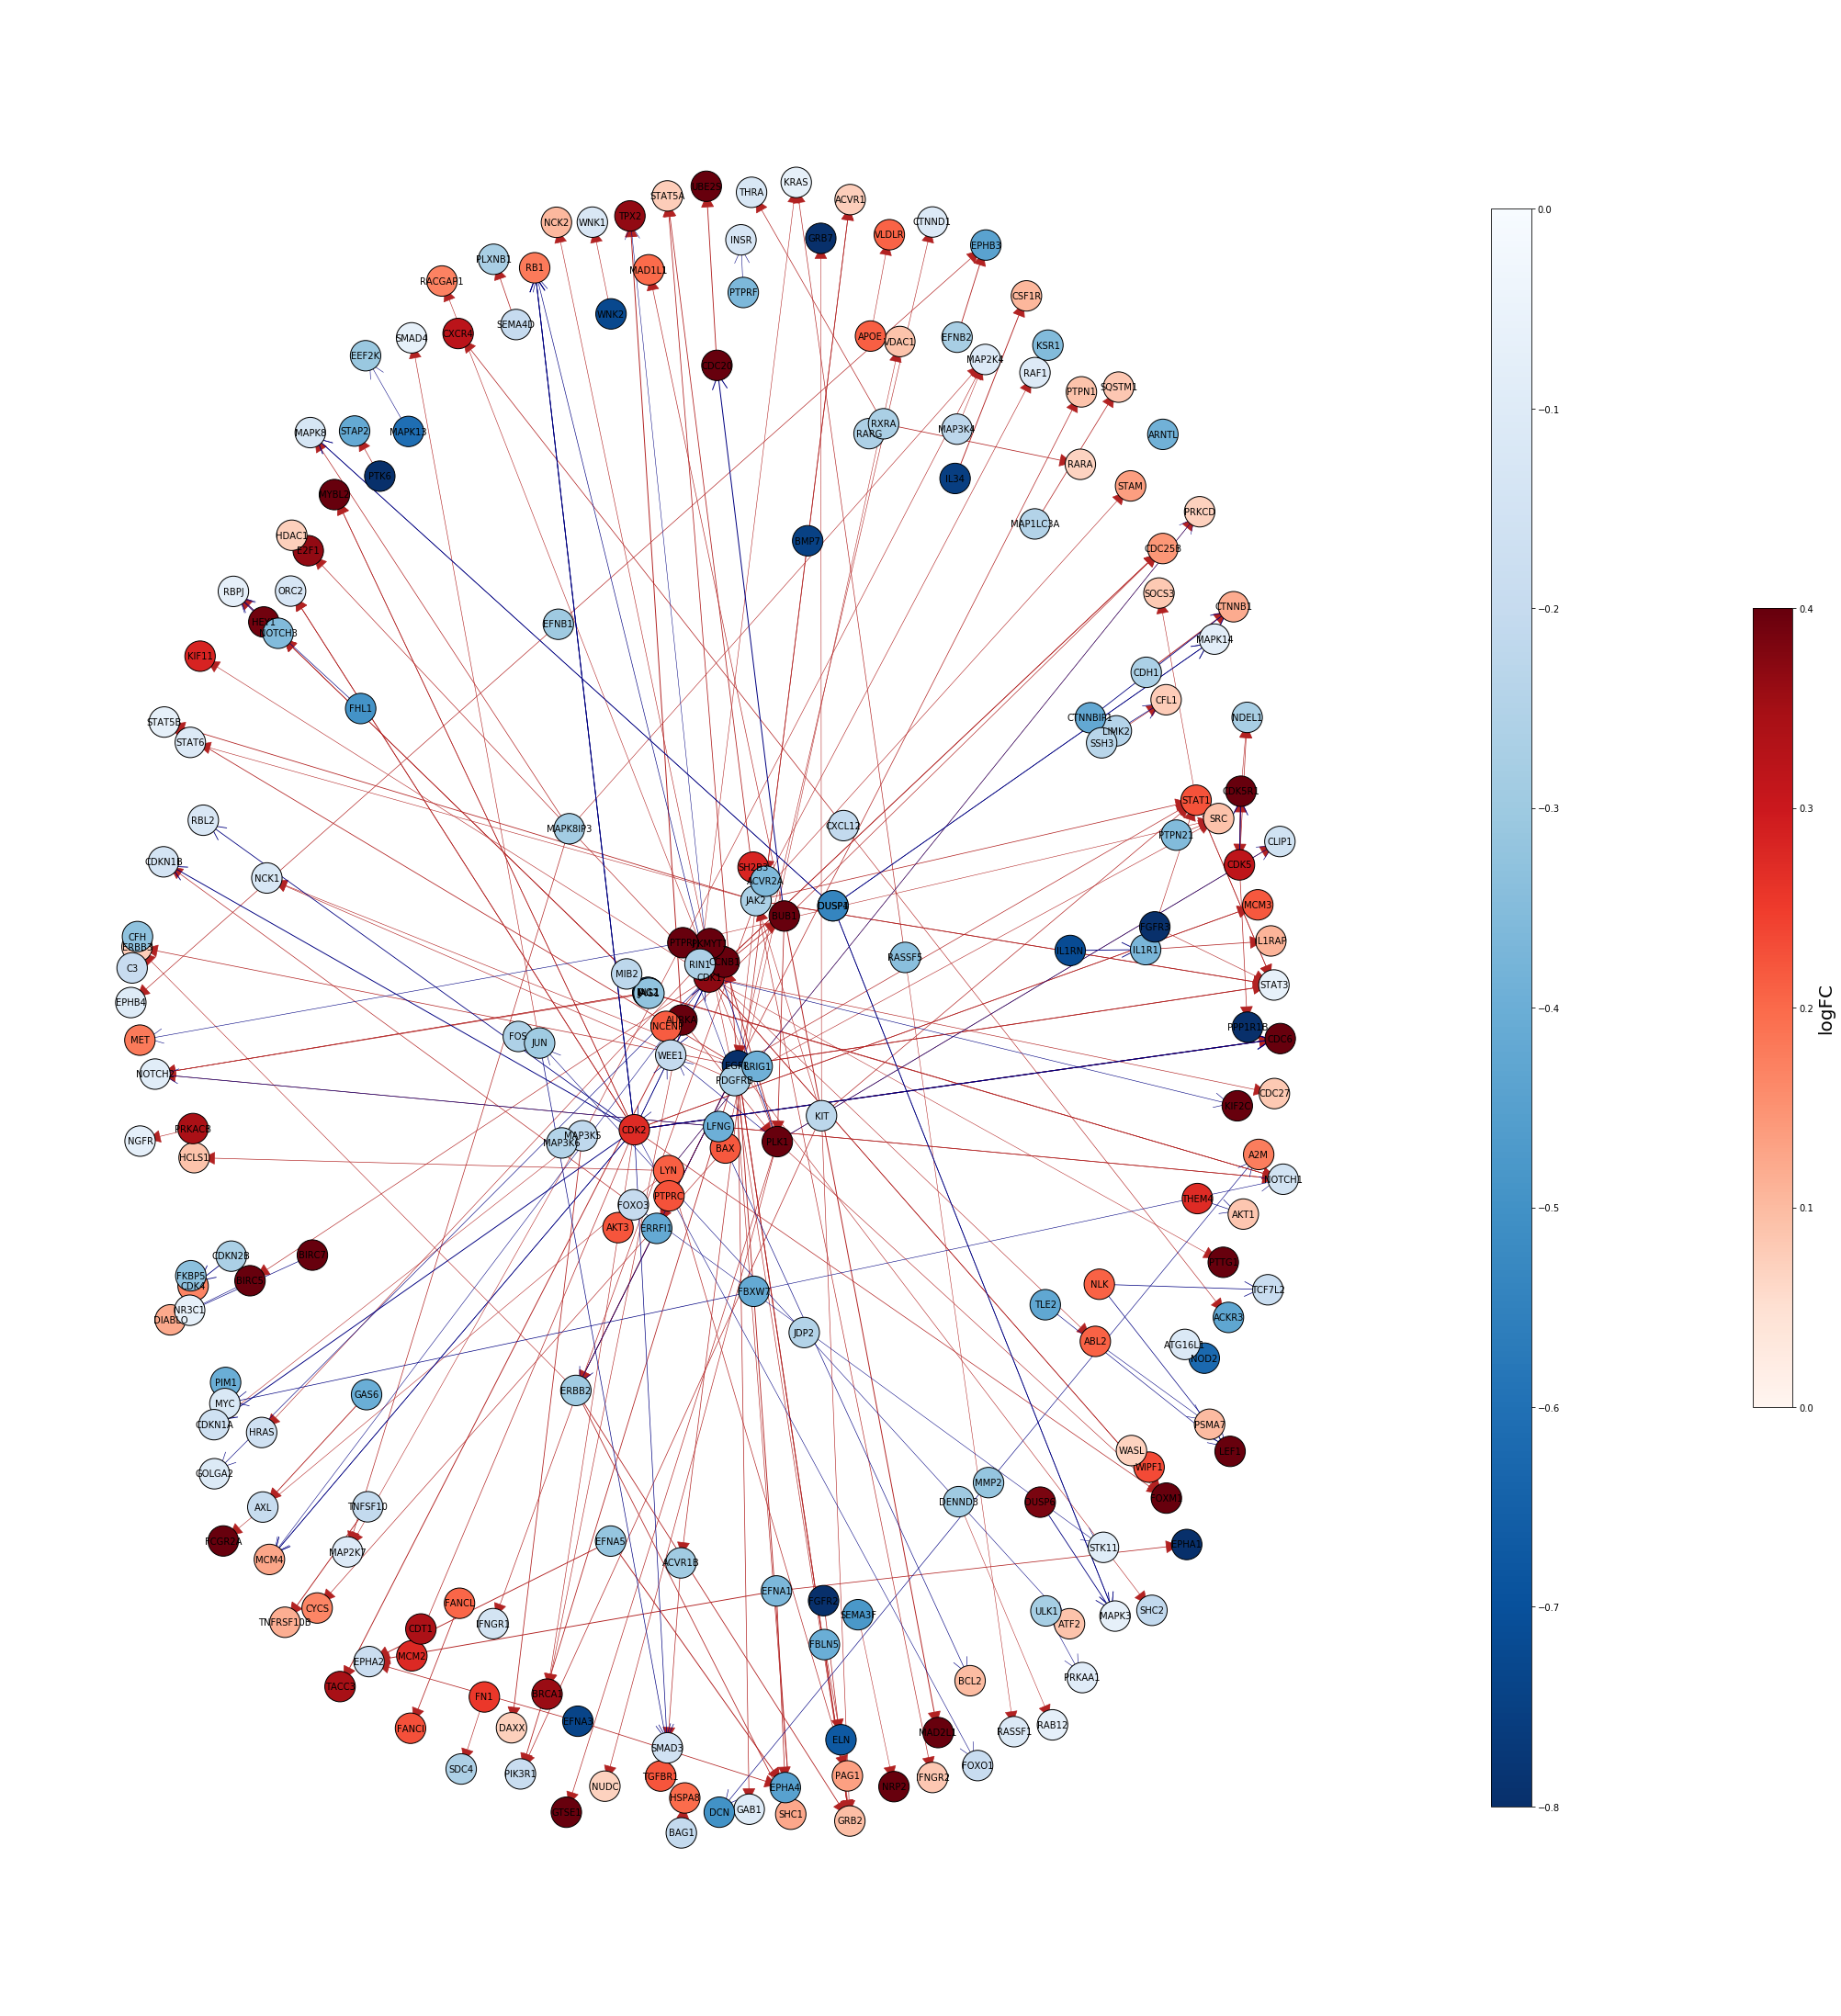

In [31]:
plt.figure(figsize=(40,40))

ec1 = nx.draw_networkx_edges(G, pos, edgelist = act_edge, width = act_weight, edge_color = 'firebrick', arrows = True, arrowsize = 32)
ec2 = nx.draw_networkx_edges(G, pos, edgelist = inh_edge, width = inh_weight, edge_color = 'navy', arrows = True, arrowstyle = '->', arrowsize = 40)

if up:
    nc1 = nx.draw_networkx_nodes(G, pos, nodelist = up, node_color = c_up, node_size = 1100, cmap = plt.cm.Reds, vmin = 0, vmax = 0.4)
    nc1.set_edgecolor('black')
if down:
    nc2 = nx.draw_networkx_nodes(G, pos, nodelist = down, node_color = c_down, node_size = 1100, cmap = plt.cm.Blues.reversed(), vmin = -0.8, vmax = 0) 
    nc2.set_edgecolor('black')
if na:
    node_color = "grey"
    nc3 = nx.draw_networkx_nodes(G, pos, nodelist = na, node_color = node_color , node_size = 1100)
    nc3.set_edgecolor('black')
        
nx.draw_networkx_labels(G, pos, labels = labels, font_size = 10)

if up:
    cb1 = plt.colorbar(nc1, ticks = [0, 0.1, 0.2, 0.3, 0.4], shrink = 0.4, pad = 0)     
if down:
    cb2 = plt.colorbar(nc2, ticks = [0, -0.1, -0.2, -0.3, -0.4, -0.5,-0.6, -0.7, -0.8], shrink = 0.8, aspect = 40)
    
if up:
    cb1.set_label('logFC', size = 20)
elif down:
    cb2.set_label('logFC', size = 20)

plt.axis('off')
plt.savefig('signor_test_2.png')
plt.show()